In [1]:
import warnings

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [4]:
import numpy as np
import mahotas as mh
image = mh.imread('scene00.jpg')
from matplotlib import pyplot as plt
plt.imshow(image)
plt.show()
image = mh.colors.rgb2grey(image, dtype=np.uint8)
plt.imshow(image) # Display the image
plt.gray()
thresh = mh.thresholding.otsu(image)
print('Otsu threshold is {}.'.format(thresh))
# Otsu threshold is 138.
plt.imshow(image > thresh)

im16 = mh.gaussian_filter(image,16)
im = mh.demos.load('lenna')

r,g,b = im.transpose(2,0,1) 
r12 = mh.gaussian_filter(r, 12.)
g12 = mh.gaussian_filter(g, 12.)
b12 = mh.gaussian_filter(b, 12.)
im12 = mh.as_rgb(r12,g12,b12)
h, w = r.shape # height and width
Y, X = np.mgrid[:h,:w]
Y = Y-h/2. # center at h/2
Y = Y / Y.max() # normalize to -1 .. +1

X = X-w/2.
X = X / X.max()

C = np.exp(-2.*(X**2+ Y**2))

# Normalize again to 0..1
C = C - C.min()
C = C / C.ptp()
C = C[:,:,None] # This adds a dummy third dimension to C

ringed = mh.stretch(im*C + (1-C)*im12)

haralick_features = mh.features.haralick(image)
haralick_features_mean = np.mean(haralick_features, axis=0)
haralick_features_all = np.ravel(haralick_features)

from glob import glob
images = glob('SimpleImageDataset/*.jpg')
features = []
labels = []
for im in images:
    labels.append(im[:-len('00.jpg')])
    im = mh.imread(im)
    im = mh.colors.rgb2gray(im, dtype=np.uint8)
    features.append(mh.features.haralick(im).ravel())

features = np.array(features)
labels = np.array(labels)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
clf = Pipeline([('preproc', StandardScaler()),
                ('classifier', LogisticRegression())])



<Figure size 640x480 with 1 Axes>

Otsu threshold is 138.


In [5]:
from sklearn import model_selection
# cv = model_selection.LeavePOut(len(images))
cv = model_selection.LeaveOneOut()
scores = model_selection.cross_val_score(
    clf, features, labels, cv=cv)
print('Accuracy: {:.1%}'.format(scores.mean()))
# Accuracy: 81.1%

Accuracy: 81.1%


In [6]:


def chist(im):
    im = im // 64
    r,g,b = im.transpose((2,0,1))
    pixels = 1 * r + 4 * b + 16 * g
    hist = np.bincount(pixels.ravel(), minlength=64)
    hist = hist.astype(float)
    hist = np.log1p(hist)
    return hist

features = []
for im in images:
    im = mh.imread(im)
    features.append(chist(im))



features = []
for im in images:
    imcolor = mh.imread(im)
    im = mh.colors.rgb2gray(imcolor, dtype=np.uint8)
    features.append(np.concatenate([
          mh.features.haralick(im).ravel(),
          chist(imcolor),
      ]))


scores = model_selection.cross_val_score(
    clf, features, labels, cv=cv)
print('Accuracy: {:.1%}'.format(scores.mean()))
# Accuracy: 95.6%

Accuracy: 96.7%


In [7]:
features = []
for im in images:
    imcolor = mh.imread(im)
    # Ignore everything in the 200 pixels close to the borders
    imcolor = imcolor[200:-200, 200:-200]
    im = mh.colors.rgb2gray(imcolor, dtype=np.uint8)
    features.append(np.concatenate([
          mh.features.haralick(im).ravel(),
          chist(imcolor),
      ]))

sc = StandardScaler()
features = sc.fit_transform(features)
from scipy.spatial import distance
dists = distance.squareform(distance.pdist(features))

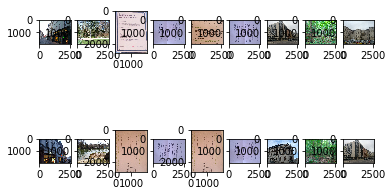

In [8]:
fig, axes = plt.subplots(2, 9)
for ci,i in enumerate(range(0,90,10)):
    left = images[i]
    dists_left = dists[i]
    right = dists_left.argsort()
    # right[0] is the same as left[i], so pick the next closest element
    right = right[1]
    right = images[right]
    left = mh.imread(left)
    right = mh.imread(right)
    axes[0, ci].imshow(left)
    axes[1, ci].imshow(right)

In [9]:
from sklearn.model_selection import GridSearchCV
C_range = 10.0 ** np.arange(-4, 3)
grid = GridSearchCV(LogisticRegression(), param_grid={'C' : C_range})
clf = Pipeline([('preproc', StandardScaler()),
               ('classifier', grid)])

In [10]:
cv = model_selection.KFold(5,shuffle=True, random_state=123)
scores = model_selection.cross_val_score(
   clf, features, labels, cv=cv)
print('Accuracy: {:.1%}'.format(scores.mean()))

/home/mars/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/mars/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/mars/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/mars/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_se

Accuracy: 93.3%


/home/mars/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [11]:
from mahotas.features import surf
image = mh.demos.load('lena')
image = mh.colors.rgb2gray(image, dtype=np.uint8)
descriptors = surf.surf(image, descriptor_only=True)

In [12]:
from mahotas.features import surf
descriptors = surf.dense(image, spacing=16)
alldescriptors = []
for im in images:
    im = mh.imread(im, as_grey=True)
    im = im.astype(np.uint8)
    alldescriptors.append(surf.dense(image, spacing=16))
# get all descriptors into a single array
concatenated = np.concatenate(alldescriptors)
print('Number of descriptors: {}'.format(
       len(concatenated)))

Number of descriptors: 51840


In [13]:
# use only every 64th vector
concatenated = concatenated[::64] 
from sklearn.cluster import KMeans # FIXME CAPITALIZATION
k = 256
km = KMeans(k)
km.fit(concatenated)

features = []
for d in alldescriptors:
    c = km.predict(d)
    features.append(
      np.array([np.sum(c == ci) for ci in range(k)])
    )


/home/mars/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (256). Possibly due to duplicate points in X.
  return_n_iter=True)


In [14]:
# build single array and convert to float
features = np.array(features, dtype=float)
scores = model_selection.cross_val_score(
   clf, features, labels, cv=cv)
print('Accuracy: {:.1%}'.format(scores.mean()))
# Accuracy: 62.6%


/home/mars/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/mars/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Accuracy: 24.4%


/home/mars/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
